In [1]:
img_path = 'cats_and_dogs_small/test/dogs/dog.1503.jpg'

from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

img_tensor.shape

Using TensorFlow backend.


(1, 150, 150, 3)

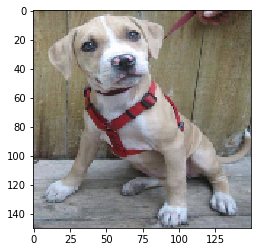

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(img_tensor[0])
plt.show()

In [1]:
'''
个人实验时，在后续调研模型的时候出现cuDNN初始化失败的情况
查阅资料后通过以下代码解决，但是每台机器的环境都不同，
可以先无视下段代码，如果出现类似情况，再使用，尝试解决。
'''
import os # 设置调用的gpu
os.environ['CUDA_VISIBLE_DEVICES'] = '/gpu:0'
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
# 设置gpu使用的显存占最大显存的比例，在跑小模型的时候是有用的
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [ ]:
from keras.models import load_model
model = load_model('cats_and_dogs_small_2.h5')
model.summary()

In [4]:
from keras import models
layer_outputs = [layer.output for layer in model.layers[:8]] 
# 提取前8层的输出
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
# 创建一个模型，给定模型输入，返回这前8层的输出

In [ ]:
activations = activation_model.predict(img_tensor)
# 返回8个Numpy数组组成的列表，每个层激活对应一个Numpy数组

first_layer_activation = activations[0]
# 第一个卷积层的激活情况
first_layer_activation.shape

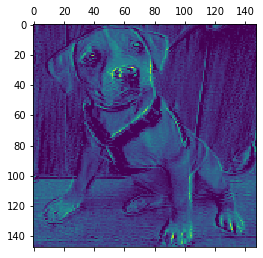

In [6]:
import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')

D:\Application\Mini3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


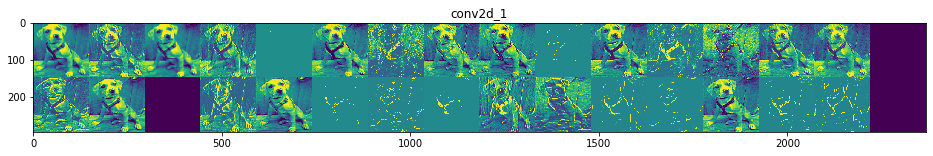

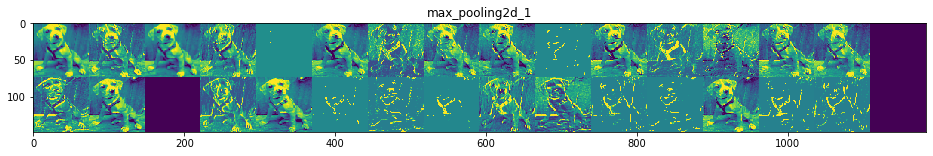

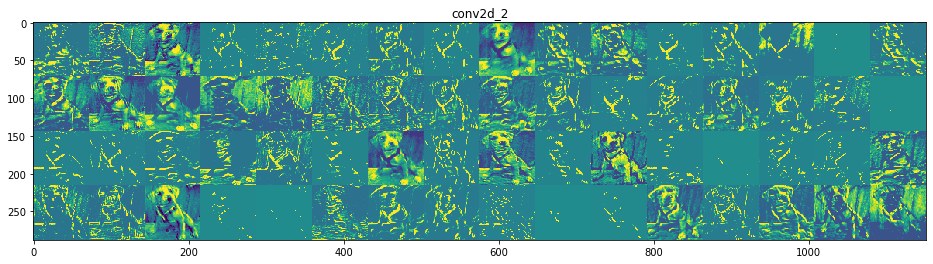

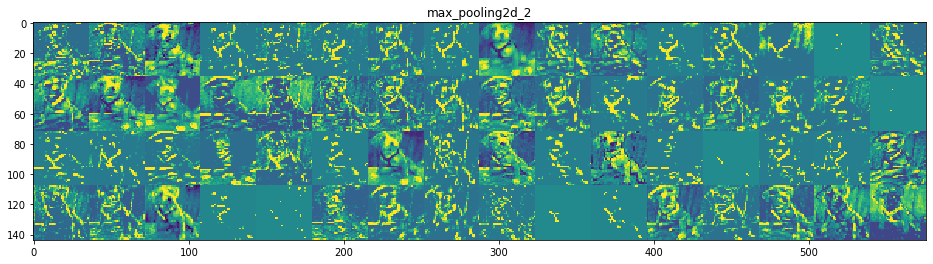

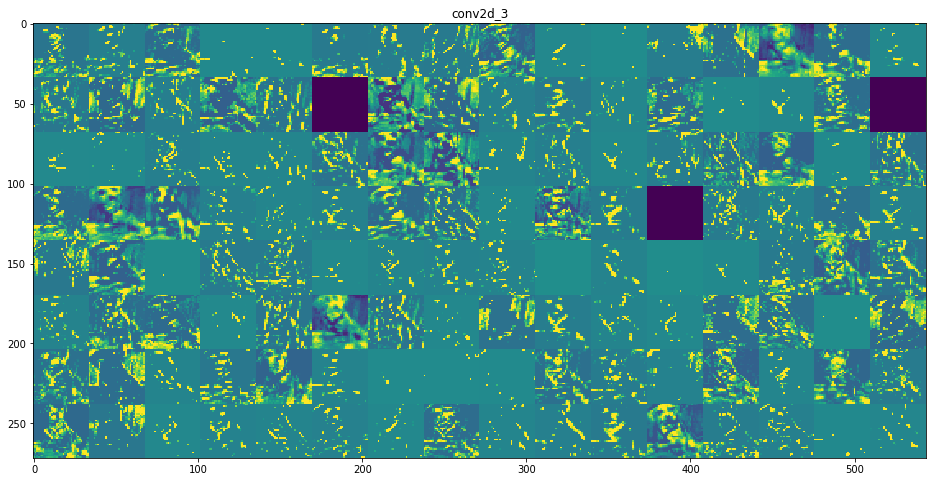

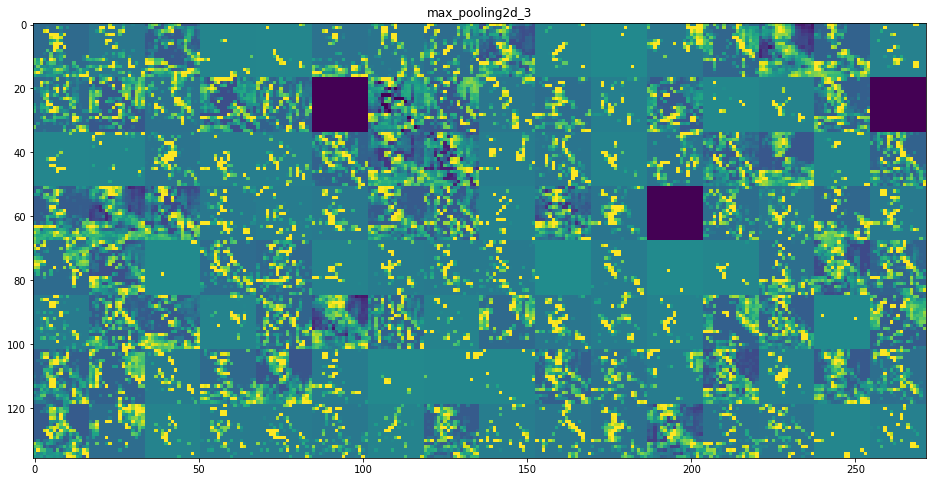

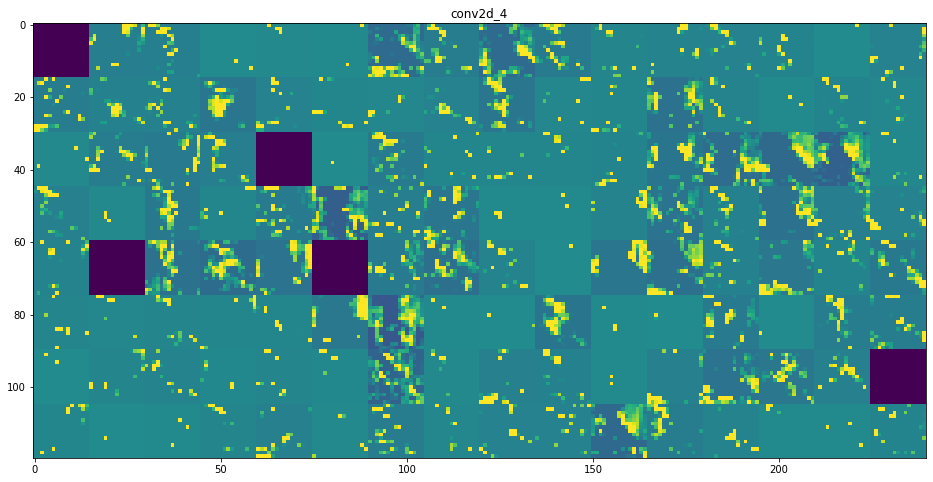

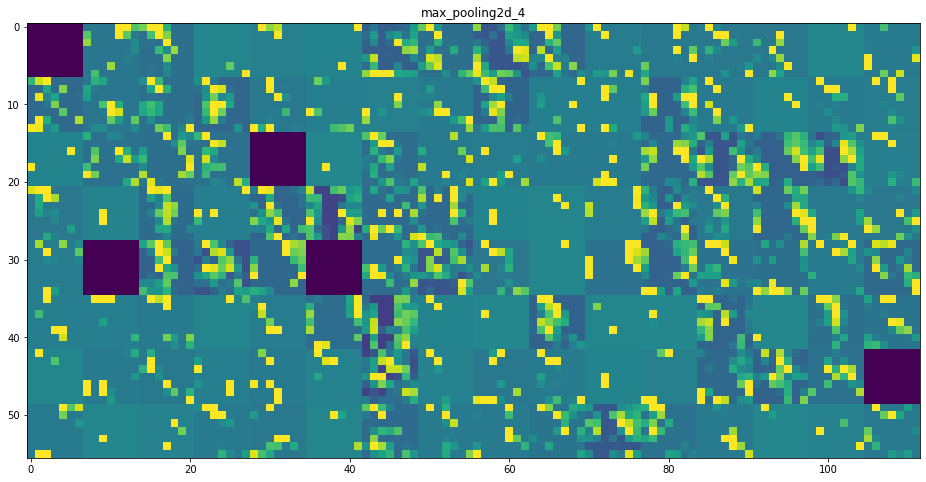

In [8]:
layer_names = [] # 将这些层的名字添加到图中
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations): 
    # 每一层的名字与其对应输出的特诊图
    n_features = layer_activation.shape[-1] # 特征图的通道数
    size = layer_activation.shape[1] # 每一张图的大小
    n_cols = n_features // images_per_row # 计算平铺的行列数
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # 将一层特征图输出的所有通道 平铺到一个大网络中
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean() # 做简单的处理更美观
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # 显示网络
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
    scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [6]:
from keras.applications import VGG16
from keras import backend as K
import numpy as np

# 和前面一样的方法导入模型
model = VGG16(weights='vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                  include_top=False, 
                  input_shape=(150, 150, 3)) 

    

In [7]:
def deprocess_image(x): 
    # 生成的图像取值可能不是[0, 255]范围区间的整数
    # 我们将其转换为可显示的图像
    x -= x.mean()
    x /= (x.std() + 1e-5) # 标准化
    x *= 0.1
    
    x += 0.5
    x = np.clip(x, 0, 1) # 将x裁切到[0,1]之间
    
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [8]:
def gen_pattern(layer_name, filter_index, size=150, iter=40):
    
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index]) # 在特征图的最后一维选择filter
    # 为了实现梯度下降，我们需要得到损失函数相对于模型输入的梯度
    # gradients返回的是一个张量列表，本次中列表长度为1，所以只保留第一个元素
    grads = K.gradients(loss, model.input)[0]
    # 为保证梯度下降的过程顺利，将梯度张量除以其L2范数（张量中所有值的平方的平均值的平方根）来标准化
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5) # 以防不小心除以0
    # 使用输入和输出来定义一个函数
    iterate = K.function([model.input], [loss, grads])
    #从一张带有噪声的灰度图像开始
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    step = 1. # 每次更新的步长
    for i in range(iter): # 更新iter次
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    return deprocess_image(input_img_data[0])

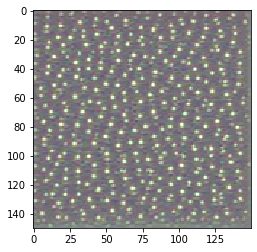

In [9]:
import matplotlib.pyplot as plt
plt.imshow(gen_pattern('block3_conv1', 0))
plt.show()

In [2]:
from keras.applications.vgg16 import VGG16
# 注意这里导入的是带有全连接层的模型权重！与之前的不同
model = VGG16(weights='vgg16_weights_tf_dim_ordering_tf_kernels.h5')

In [3]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = 'cats_and_dogs_small/test/dogs/dog.1528.jpg'
# 将图像转换为VGG16能读取的224*224的大小
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img) # 转换成224*224*3的数组
x = np.expand_dims(x, axis=0) # 转换成1*224*224*3
x = preprocess_input(x) # 预处理（按通道进行颜色标准化）

In [4]:
preds = model.predict(x) # 使用vgg16预测这种图片
# decode_predictions将preds结果转换为对应的类别(文字)，同时我们只取前三个
print(decode_predictions(preds, top=3)[0])
# 找到preds预测的最可能的类的index
print(np.argmax(preds[0]))

[('n02113023', 'Pembroke', 0.8551878), ('n02113186', 'Cardigan', 0.14406267), ('n02085620', 'Chihuahua', 9.773286e-05)]
263


In [5]:
from keras import backend as K
# model.output的第一维是批次中输入图片的数量
# 第二维是分类得到的品种的概率，去除刚刚找到的那个Index
image_output = model.output[:, 263]
# vgg16的最后一个卷积层
last_conv_layer = model.get_layer('block5_conv3')
# 这个类别相对于block5_conv3的输出特征图的梯度
# K.gradients([y], [x])返回的是一个与[x]长度一样的list所以我们取第一个
grads = K.gradients(image_output, [last_conv_layer.output])[0]
# grads.shape是(?,14,14,512),?表示未知的一批次中输入的图片数目
# 我们这里只输入了一张照片?等于1，我们针对前三个维度求平均
# pooled_prads的维度是(512,)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
# 这个函数的输入的维度是(?,224,224,3) ?取1
# 输出分别是(512,) (?,14,14,512)[0]即(14,14,512)
iterate = K.function([model.input],
                     [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(512): # 用类别相对于通道的梯度对这个特征图中的每个通道进行加权
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
# 对512个通道取平均，得到（14,14）的“热力图”
heatmap = np.mean(conv_layer_output_value, axis=-1) 

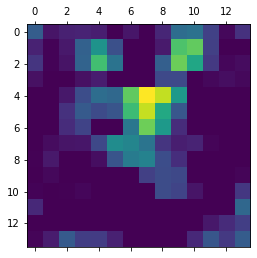

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
# 把热力图的值归一化到0-1才能显示
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [7]:
import cv2
img = cv2.imread(img_path)
# 将14*14的热力图缩放至于dog.1528.jpg一样大
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
# 将0-1的热力值缩放至0-255
heatmap = np.uint8(255 * heatmap)
# 将热力值转换为伪色彩
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
# 图片叠加
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('image_cam.jpg', superimposed_img)

True

TensorShape([Dimension(None), Dimension(14), Dimension(14), Dimension(512)])